<a href="https://colab.research.google.com/github/vubanc/BikeTimeSeriesAnalysis/blob/main/TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the Libraries and Notebooks**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [329]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import timedelta
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [422]:
df = pd.read_csv("/content/drive/MyDrive/Work/Bikesharing/CombinedRentals_AllStations.csv")
df.head(2)

,index,id,user,user_id,user_phone,start_station,start_time,start_time_local,end_station,end_time,end_time_local,kilometers,miles,message_count,type,duration (seconds),rating,device_id,bike_type,Date
0,1,34ac1576-891f-4aca-a570-31db6160fd6f,Dara Ochoa,2112677d-b644-4cb8-866d-58f52b932f76,14792852353,Riverfront Park,2023-08-02 01:09:31.952446+00:00,2023-08-01 19:09:31.952446-06:00,Riverfront Park,2023-08-02 01:10:19.952446+00:00,2023-08-01 19:10:19.952446-06:00,NaN,NaN,130,22,48.0,NaN,74164be4e769c0ff30f08acb19724fa186d89b71913e9b...,Regular Bike,2023-08-01
1,2,dc96b3e6-f607-452b-ad18-79ea96e033d9,Gervon Pennington,79ea58b0-0988-47da-b963-a11a52a94f04,19035560048,Riverfront Park,2023-08-02 00:48:53.349677+00:00,2023-08-01 18:48:53.349677-06:00,Riverfront Park,2023-08-02 01:24:14.349677+00:00,2023-08-01 19:24:14.349677-06:00,4.482,2.78498,41,22,2121.0,NaN,fMV1Kdc8Km,Regular Bike,2023-08-01


## **EDA & Data Preprocessing**

In [424]:
#Data Manipulation (monthly trips)
df.rename(columns={"Date":"date"}, inplace=True)
df["month"] = pd.to_datetime(df["date"]).dt.strftime("%Y-%m")
df_monthlyTrips = df.groupby("month", as_index=False)["id"].count()
df_monthlyTrips.rename(columns={"id":"trip_count"}, inplace=True)
df_monthlyTrips.set_index("month", inplace=True)
df_monthlyTrips.head(2)

,trip_count
month,
2022-05,364
2022-06,316


In [425]:
#Data Manipulation (daily trips)
min_date = df["date"].min()
max_date = df["date"].max()
dates = pd.DataFrame(pd.date_range(start=min_date, end=max_date))
dates.rename(columns={0:"date"}, inplace=True)
dates["date"] = dates.date.dt.strftime("%Y-%m-%d")
df = pd.merge(df, dates, how="right", on="date")
df.sort_values(by = ["date", "start_time"], inplace=True, ascending=[True,True])

df_dailyTrips = df.groupby("date", as_index=False)["id"].count()
df_dailyTrips.rename(columns={"id":"trip_count"}, inplace=True)
df_dailyTrips.date = pd.to_datetime(df_dailyTrips.date)
df_dailyTrips.set_index("date", inplace=True)
df_dailyTrips.head(2)

,trip_count
date,
2022-05-02,2
2022-05-03,14


Trend

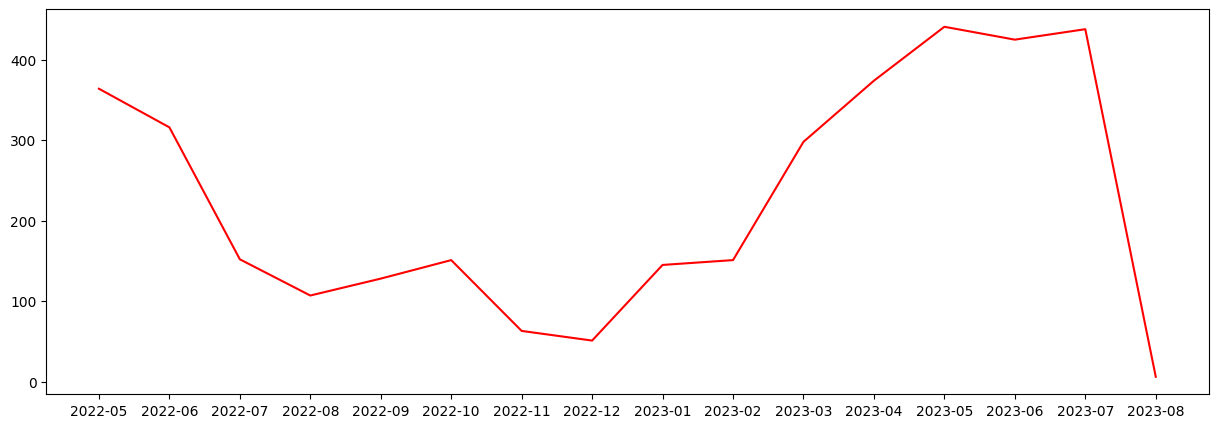

In [432]:
#Monthly Trend
fig, axs = plt.subplots(1,1, figsize=(15,5))
plt.plot(df_monthlyTrips['trip_count'], color="red")

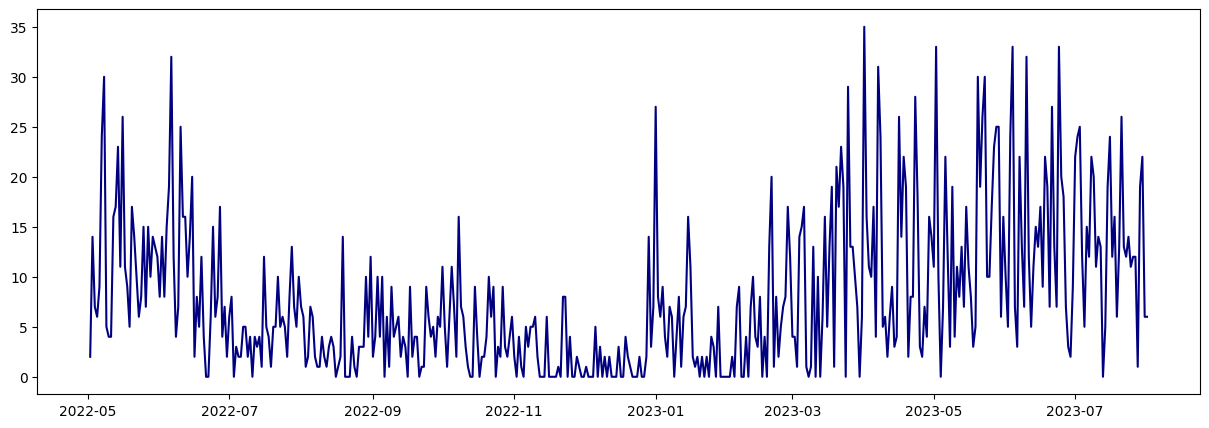

In [180]:
#Daily Trend
fig, axs = plt.subplots(1,1, figsize=(15,5))
plt.plot(df_dailyTrips['trip_count'], color="navy")

Autocorrelation

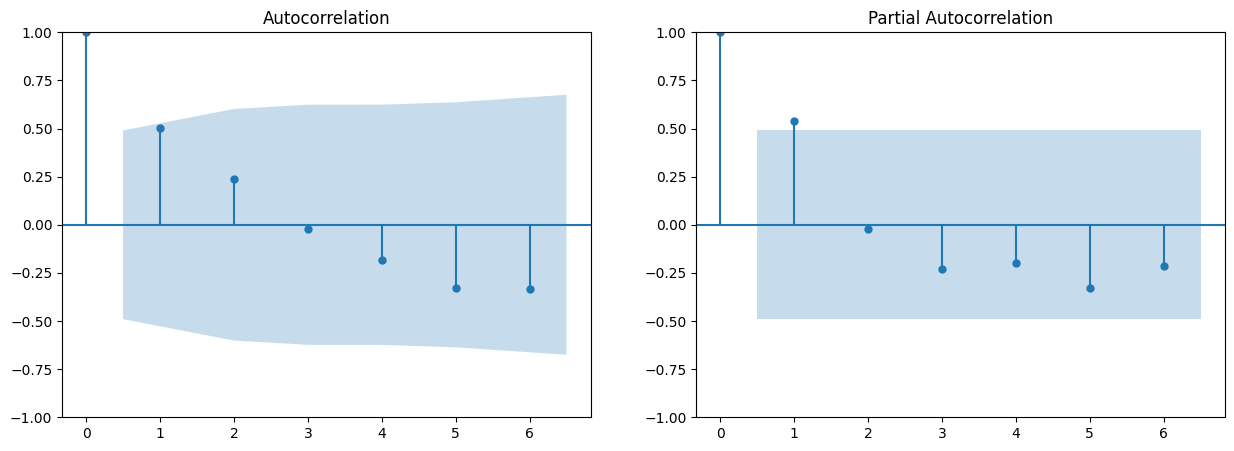

In [438]:
#ACF & PACF plots(monthly)
fig, axs = plt.subplots(1,2,figsize=(15,5))
plot_acf(x=df_monthlyTrips.trip_count, ax=axs[0], lags=6)
plot_pacf(x=df_monthlyTrips.trip_count, ax=axs[1], lags=6)
plt.show()

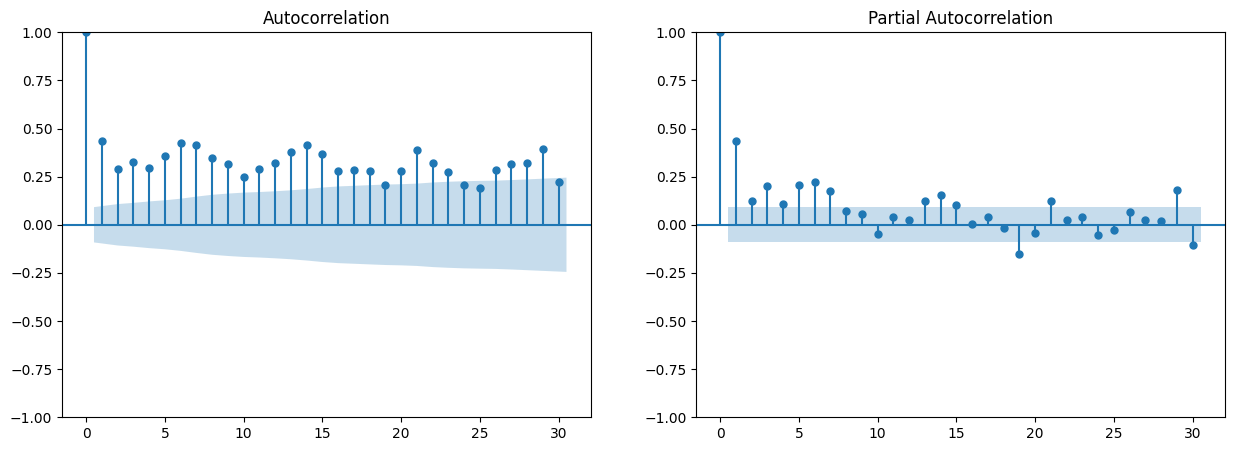

In [440]:
#ACF & PACF plots (daily)
fig, axs = plt.subplots(1,2,figsize=(15,5))
plot_acf(x=df_dailyTrips.trip_count, ax=axs[0], lags=30)
plot_pacf(x=df_dailyTrips.trip_count, ax=axs[1], lags=30)
plt.show()

Stationarity

In [441]:
#Augmented Dickey-Fuller Test
result = adfuller(df_monthlyTrips)
print(f"The ADF test statistic for monthly trips: {result[0]}")
print(f"The ADF p-value for monthly trips: {result[1]}")

The ADF test statistic for monthly trips: -34.16289988739043
The ADF p-value for monthly trips: 0.0


In [442]:
#Augmented Dickey-Fuller Test
result = adfuller(df_dailyTrips)
print(f"The ADF test statistic for daily trips: {result[0]}")
print(f"The ADF p-value for daily trips: {result[1]}")

The ADF test statistic for daily trips: -1.967538455776848
The ADF p-value for daily trips: 0.30098516341276804


**From the ADF tests, two observations can be made:**
*   The monthly data is stationary and a time-series model such as AR, MA or ARMA can be directly applied.
*   The daily data is not stationary. Hence, an ARIMA model with a 'd' parameter needs to be used.



In [443]:
#Applying differencing to dailyTrips
df_dailyTrips["diff_trip_count"] = df_dailyTrips['trip_count'].diff().fillna(0).astype(int)
df_dailyTrips.head(5)

,trip_count,diff_trip_count
date,,
2022-05-02,2,0
2022-05-03,14,12
2022-05-04,7,-7
2022-05-05,6,-1
2022-05-06,9,3


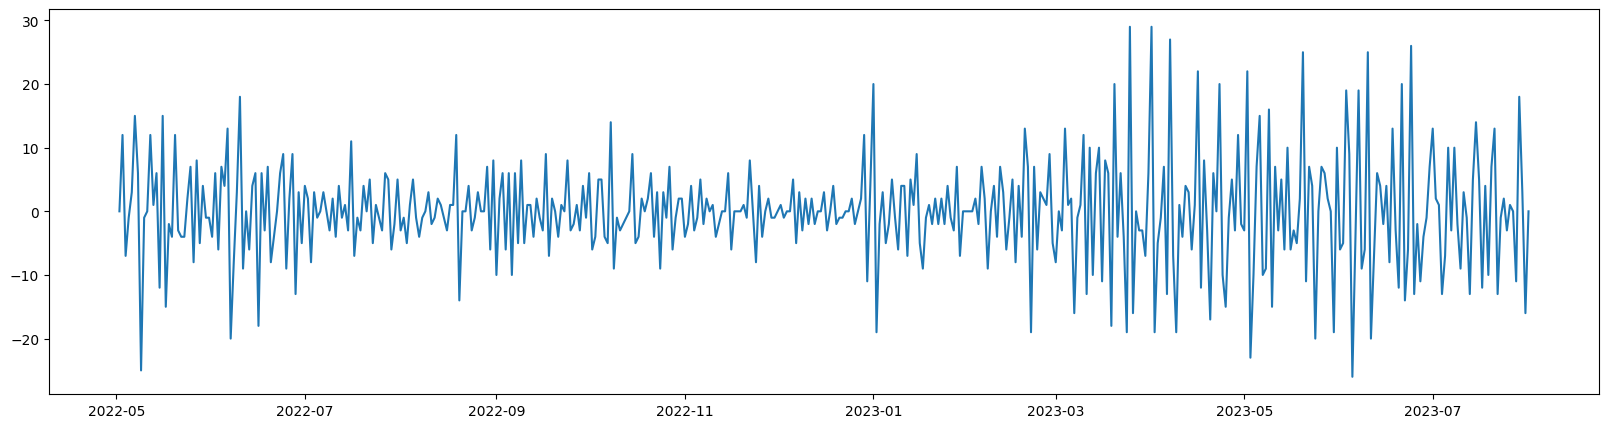

In [444]:
#Daily data after applying the transformation
fig = plt.figure(figsize=(20,5))
plt.plot(df_dailyTrips.diff_trip_count)

In [445]:
#Augmented Dickey-Fuller Test on the transformed data
result = adfuller(df_dailyTrips.diff_trip_count)
print(f"The ADF test statistic is: {result[0]}")
print(f"The ADF p-value is: {result[1]}")

The ADF test statistic is: -6.480879566160753
The ADF p-value is: 1.2959848279813883e-08


The ADF test suggests that applying differencing transformation by one period makes the data stationary. Hence, an ARIMA model with d=1 should be sufficient.

## **ARIMA Model Fitting**

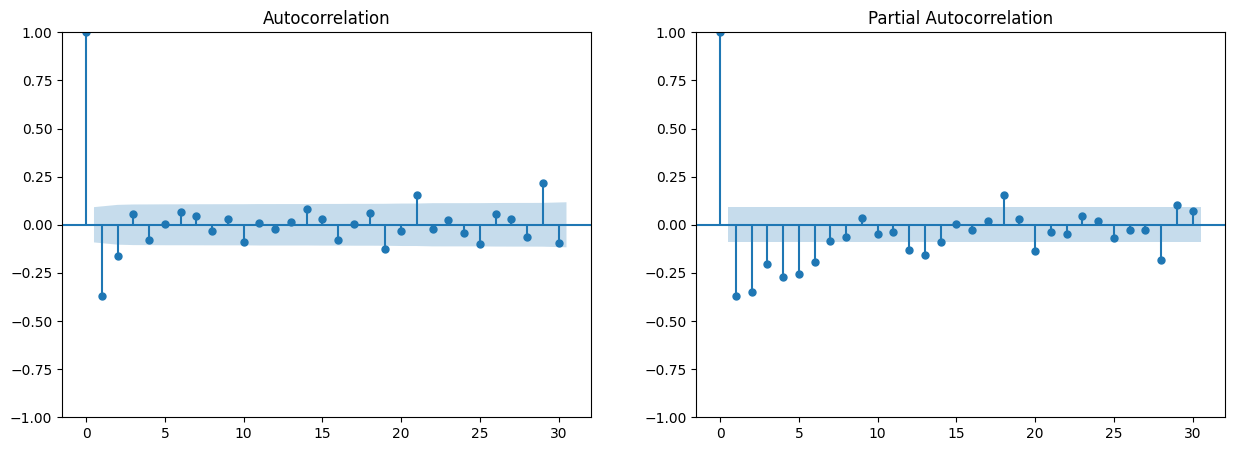

In [594]:
#ACF and PACF for transformed daily data
fig, axs= plt.subplots(1,2, figsize=(15,5))
plot_acf(x=df_dailyTrips.diff_trip_count, ax=axs[0], lags=30)
plot_pacf(x=df_dailyTrips.diff_trip_count, ax=axs[1], lags=30)
plt.show()

The ACF and PACF plots suggest that an ARIMA model of order (6,1,2) should fit the daily data well.

In [595]:
#Training and testing data
df_train_monthly = df_monthlyTrips[["trip_count"]][:"2022-12"]
df_test_monthly = df_monthlyTrips[["trip_count"]]["2023-01":"2023-07"]

df_train_daily = df_dailyTrips[["trip_count"]][:'2023-06-30']
df_test_daily = df_dailyTrips[["trip_count"]]['2023-07-01':]

In [596]:
#Fixed window predictions (monthly)
monthly_model = AutoReg(endog=df_train_monthly, lags=1).fit()
monthly_predictions = monthly_model.predict(start=0, end=len(df_monthlyTrips)-1)

In [597]:
#Fixed window predictions (daily)
daily_model = ARIMA(endog=df_train_daily.asfreq("D"), order=(6,1,2), freq='D').fit()
daily_predictions = daily_model.predict(start=0, end=len(df_dailyTrips)-1)

In [606]:
#Rolling window origin predictions (monthly)
monthly_predictions = {'month':[], 'trip_count':[]}
for month in df_test_monthly.index:
  train_end = list(df_monthlyTrips.index).index(month)
  train_data = df_monthlyTrips[["trip_count"]][:train_end] #train_end here is a numeric index. Hence, the last one will be excluded
  monthly_model = ARIMA(endog=train_data, order=(2,0,1)).fit()
  monthly_predictions['month'].append(month)
  monthly_predictions['trip_count'].append(monthly_model.forecast().astype(int))

monthly_predictions = pd.DataFrame(monthly_predictions).set_index('month')
print(monthly_model.summary())

                               SARIMAX Results                                
Dep. Variable:             trip_count   No. Observations:                   14
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -77.098
Date:                Tue, 08 Aug 2023   AIC                            164.197
Time:                        18:02:48   BIC                            167.392
Sample:                    05-01-2022   HQIC                           163.901
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        228.5753     59.436      3.846      0.000     112.082     345.068
ar.L1          1.7307      0.193      8.972      0.000       1.353       2.109
ar.L2         -0.9232      0.139     -6.651      0.0

In [604]:
#Rolling window origin predictions (daily)
daily_predictions = {'date':[], 'trip_count':[]}

for date in df_test_daily.index:
  daily_predictions['date'].append(date)

  train_data = df_dailyTrips[["trip_count"]][:date-timedelta(days=1)]
  train_data = train_data.asfreq('D')
  daily_model = ARIMA(endog=train_data, order=(6,1,2), freq='D').fit()
  prediction = daily_model.forecast().astype(int)
  daily_predictions['trip_count'].append(prediction)
  print(prediction)

daily_predictions = pd.DataFrame(daily_predictions).set_index('date')
print(daily_model.summary())

2023-07-01    15
Freq: D, dtype: int64
2023-07-02    16
Freq: D, dtype: int64
2023-07-03    14
Freq: D, dtype: int64
2023-07-04    14
Freq: D, dtype: int64
2023-07-05    11
Freq: D, dtype: int64
2023-07-06    11
Freq: D, dtype: int64
2023-07-07    15
Freq: D, dtype: int64
2023-07-08    15
Freq: D, dtype: int64
2023-07-09    18
Freq: D, dtype: int64
2023-07-10    15
Freq: D, dtype: int64
2023-07-11    13
Freq: D, dtype: int64
2023-07-12    14
Freq: D, dtype: int64
2023-07-13    14
Freq: D, dtype: int64
2023-07-14    13
Freq: D, dtype: int64
2023-07-15    14
Freq: D, dtype: int64
2023-07-16    15
Freq: D, dtype: int64
2023-07-17    15
Freq: D, dtype: int64
2023-07-18    12
Freq: D, dtype: int64
2023-07-19    12
Freq: D, dtype: int64
2023-07-20    9
Freq: D, dtype: int64
2023-07-21    14
Freq: D, dtype: int64
2023-07-22    17
Freq: D, dtype: int64
2023-07-23    13
Freq: D, dtype: int64
2023-07-24    14
Freq: D, dtype: int64
2023-07-25    12
Freq: D, dtype: int64
2023-07-26    13
Freq: D, 

## **ARIMA Model Evaluation**

p-value for ADF test of the residuals is: 0.010485950637840025


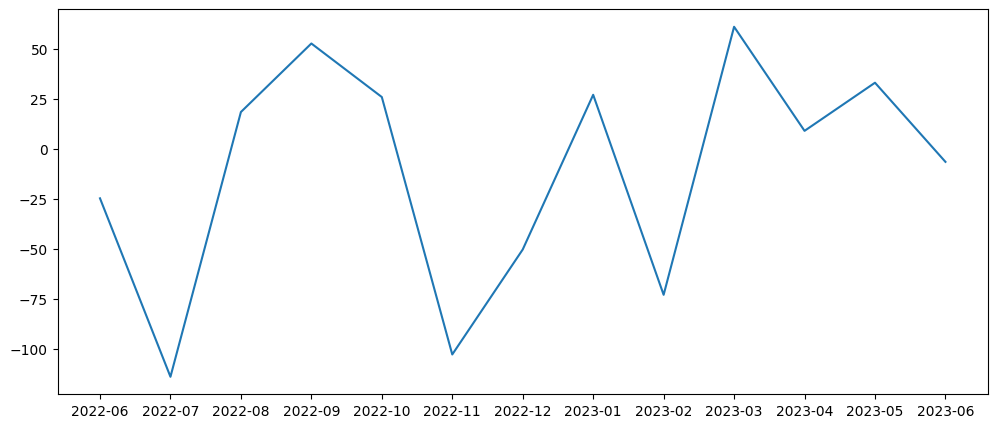

In [607]:
#Checking for white noise in the residuals (monthly)
residuals =  monthly_model.resid[1:]
plt.figure(figsize=(12,5))
plt.plot(residuals)
print(f"p-value for ADF test of the residuals is: {adfuller(residuals)[1]}")
plt.show()

p-value for ADF test of the residuals is: 0.0


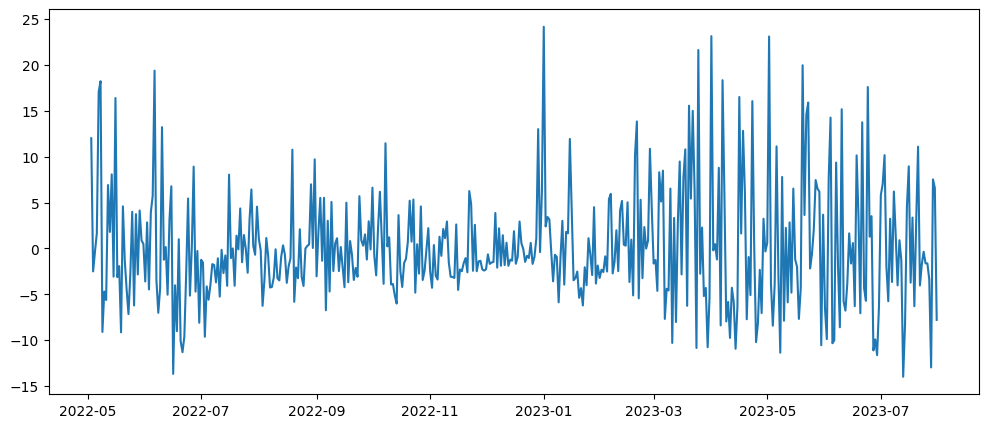

In [608]:
#Checking for white noise in the residuals (daily)
residuals = daily_model.resid[1:]
plt.figure(figsize=(12,5))
plt.plot(residuals)
print(f"p-value for ADF test of the residuals is: {adfuller(residuals)[1]}")
plt.show()

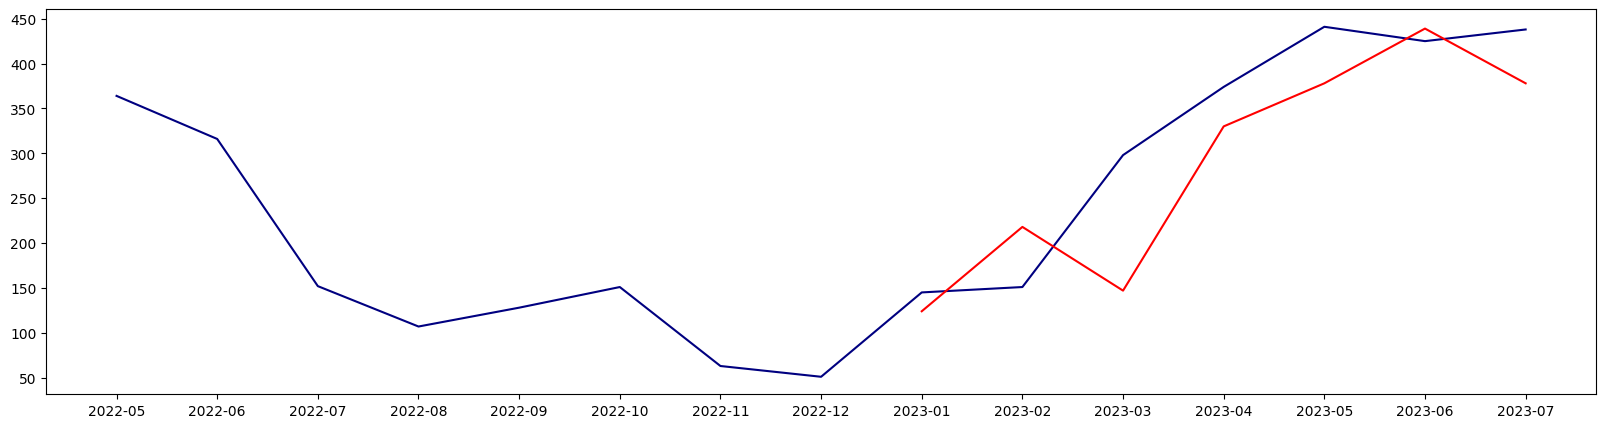

In [609]:
#True trip count vs predicted trip count (monthly)
plt.figure(figsize=(20,5))
plt.plot(df_monthlyTrips[:"2023-07"], color='navy')
plt.plot(monthly_predictions.astype(int), color='red')

In [610]:
#Root mean-squared error (monthly)
rmse_monthly = np.sqrt(mean_squared_error(df_test_monthly, monthly_predictions.astype(int)))
print(f"rmse for monthly trip predictions: {rmse_monthly}")

rmse for monthly trip predictions: 73.12611415512636


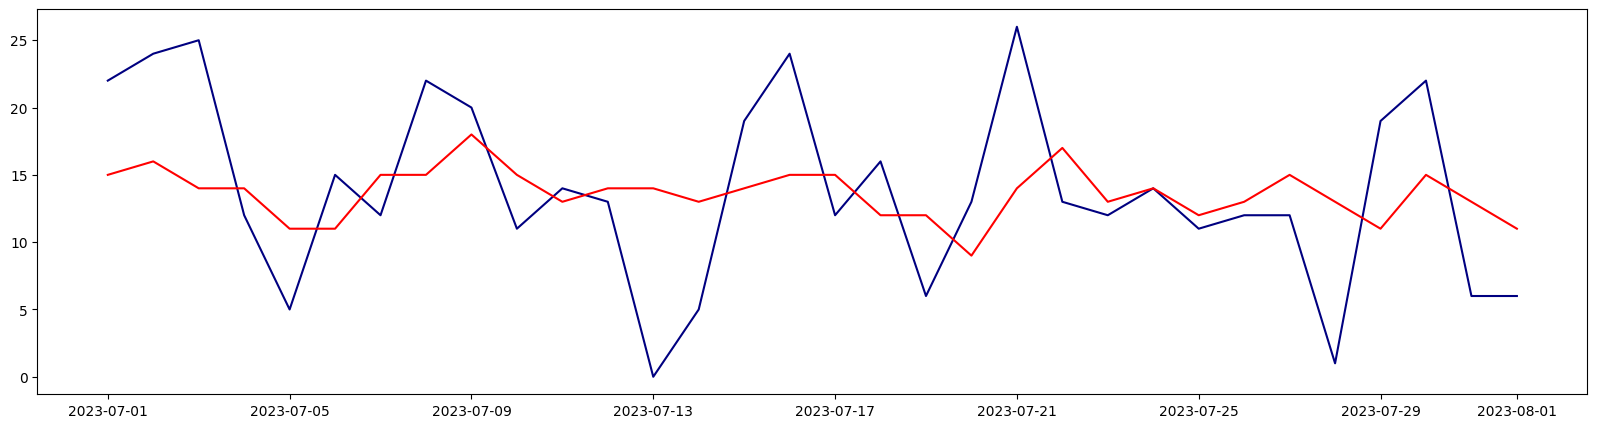

In [611]:
#True trip count difference vs predicted trip count difference (daily)
plt.figure(figsize=(20,5))
plt.plot(df_dailyTrips["trip_count"]["2023-07-01":], color="navy")
plt.plot(daily_predictions["trip_count"]["2023-07-01":], color="red")
plt.show()

In [612]:
#Root mean-squared error (daily)
rmse = np.sqrt(mean_squared_error(df_test_daily, daily_predictions["trip_count"]["2023-06-30":].astype(int)))
print(f"Root mean squared error: {rmse}")

Root mean squared error: 6.41287766919033
